In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!ls drive

'My Drive'


The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

train.csv contains two columns, "emotion" and "pixels". The "emotion" column contains a numeric code ranging from 0 to 6, inclusive, for the emotion that is present in the image. The "pixels" column contains a string surrounded in quotes for each image. The contents of this string a space-separated pixel values in row major order. test.csv contains only the "pixels" column and your task is to predict the emotion column.

The training set consists of 28,709 examples.

In [0]:
import os
from glob import glob
from tqdm import tqdm
import math

# helper libraries
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.ion()   # interactive mode

# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [0]:
root = os.path.join('./','drive','My Drive','dl_data','fer2013')
root

'./drive/My Drive/dl_data/fer2013'

In [0]:
base_dir = os.path.join(root,'fer2013.csv')
df_initial = pd.read_csv(base_dir)
emotion_type_dict = {
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprise", 
    6:"Neutral"
}
# df_initial.sample(5)
width = height = int(math.sqrt(len(df_initial['pixels'].iloc[0].split())))
df_initial['EmotionType'] = df_initial['emotion'].map(emotion_type_dict.get)

the images in the csv file are stored with the corresponding pixel values on each row and preprocessing on the data is required

In [0]:
df_initial.head(5)

,emotion,pixels,Usage,EmotionType
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,Angry
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,Angry
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,Fear
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,Sad
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,Neutral


In [0]:
!ls

drive  sample_data


In [0]:
faces = []
pixels = df_initial['pixels'].tolist()
for sequence in pixels:
    face = [int(pixel) for pixel in sequence.split()]
    face = np.asarray(face).reshape(width, height)
    faces.append(face.astype(np.uint8))
faces = np.asarray(faces)

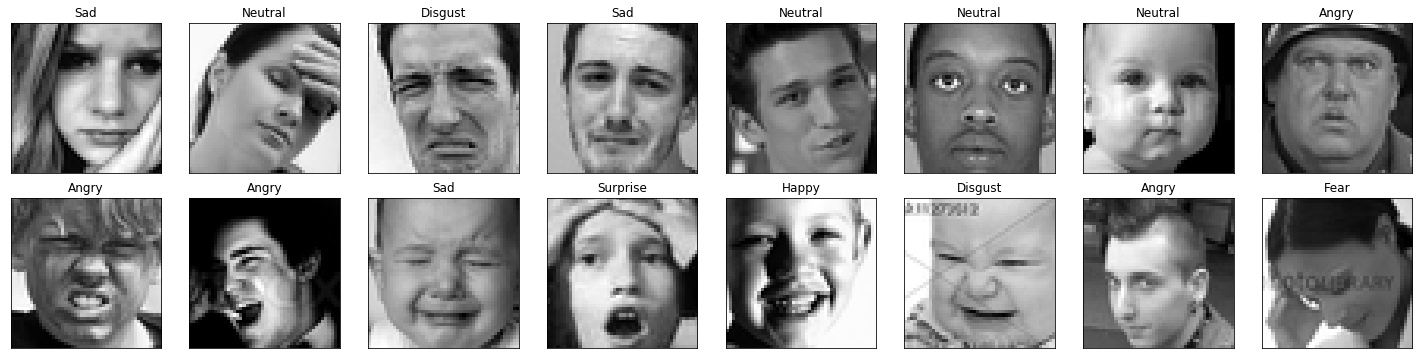

In [0]:
w, h = 8, 8
fig = plt.figure(figsize=(20, 5))
columns, rows = 8, 2
start, end = 0, len(faces) -1
ax = []
import random
for i in range(columns*rows):
    k = random.randint(start, end)
    img = faces[k]
    title = (df_initial.iloc[k,0])
    title = emotion_type_dict[title]
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title(title)  # set title
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap="gray")
plt.tight_layout(True)
plt.show()  # finally, render the plot

In [0]:
df_initial['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [0]:
df_initial['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [0]:
df_train = df_initial[df_initial['Usage']=='Training']
df_test = df_initial[df_initial['Usage']=='PublicTest']
df_val = df_initial[df_initial['Usage']=='PrivateTest']

<Figure size 1080x504 with 0 Axes>

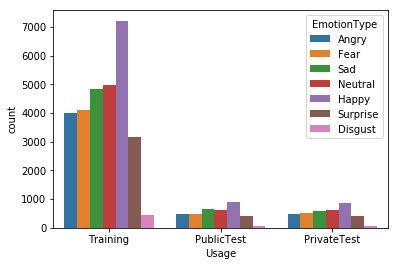

<Figure size 1080x504 with 0 Axes>

In [0]:
import seaborn as sns
sns.countplot(data=df_initial,x='Usage',hue='EmotionType')
plt.figure(figsize=(15,7))




<Figure size 1080x504 with 0 Axes>

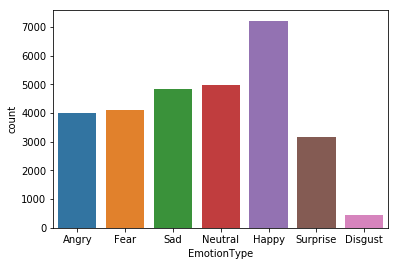

<Figure size 1080x504 with 0 Axes>

In [0]:

sns.countplot(data=df_train,x='EmotionType')
plt.figure(figsize=(15,7))

From From the above statistics of each category, we can see that there is a serious class imbalance in the training data. To solve this problem, I think we can start from two aspects, one is equalization sampling, and the other is a loss function that can be used to mitigate category imbalance during training, such as focal loss.

In [0]:
data_count = df_train['emotion'].value_counts()
max_data = max(data_count)
data_aug_rate = list()
for i in range(len(data_count)):
    data_aug_rate.append(int(round(max_data/data_count[i]))-1)

# Copy fewer class to balance the number of 7 classes
for i in range(7):
    if data_aug_rate[i]:
        df_train=df_train.append([df_train.loc[df_train['emotion'] == i,:]]*(data_aug_rate[i]), ignore_index=True)
df_train['emotion'].value_counts()

2    8194
0    7990
1    7412
3    7215
5    6342
6    4965
4    4830
Name: emotion, dtype: int64

<Figure size 1080x504 with 0 Axes>

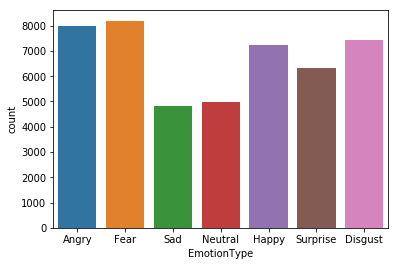

<Figure size 1080x504 with 0 Axes>

In [0]:
sns.countplot(data=df_train,x='EmotionType')
plt.figure(figsize=(15,7))

Now, this is a much balanced dataset. We can start training on this.

In [0]:
len(df_val)

3589

In [0]:
def arr_to_img(arr):
    return np.asarray([int(pixel) for pixel in arr.split()]).reshape(width, height).astype(np.uint8)

In [0]:
def compute_img_mean_std(img_arr):
    # computing the mean and std of on the whole dataset
    
    imgs = [np.asarray(i.flatten()) for i in img_arr]
    imgs = np.asarray(imgs)
#     imgs /= 255.0
    means = np.mean(imgs)
    stdevs = np.std(imgs)

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [0]:
norm_mean, norm_std = compute_img_mean_std(faces)
norm_mean = [norm_mean]
norm_std = [norm_std]

normMean = 129.38585663274074
normStd = 65.05789230083087


In [0]:
# Define a pytorch dataloader for this dataset
class FRE2013(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = arr_to_img(self.df['pixels'].iloc[index])
        X = X[:, :, np.newaxis]
        X = np.concatenate((X, X, X), axis=2)        
        X = Image.fromarray(X)
        y = torch.tensor(int(self.df['emotion'].iloc[index]))
        if self.transform:
            X = self.transform(X)

        return X, y

In [0]:
# np.asarray(Image.fromarray(faces[0]).convert('LA')).shape
# img = faces[2].flatten()
# img = img[:, :, np.newaxis]
# img = np.concatenate((img, img, img), axis=2)        
# img = Image.fromarray(img)
# np.asarray(img).shape

In [0]:
# norm_mean, norm_std = [0.5073955162068291], [0.2551289894150225]
train_transform = transforms.Compose([
                                      transforms.RandomCrop(44),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(norm_mean, norm_std),
                                     ])
# define the transformation of the val images.
val_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [0]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = FRE2013(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=64, shuffle=True, num_workers=4)
# Same for the validation set:
validation_set = FRE2013(df_val, transform=val_transform)
val_loader = DataLoader(validation_set, batch_size=64, shuffle=False, num_workers=4)

In [0]:
# next(iter(train_loader))

In [0]:
# feature_extract is a boolean that defines if we are finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [0]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224


    elif model_name == "densenet":
        """ Densenet121
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

In [0]:
# resnet,vgg,densenet,inception
model_name = 'densenet'
num_classes = 7
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = nn.Sequential(
#     nn.Conv2d(in_channels=1, out_channels=3, kernel_size=4),
#     model_ft
# )
# model.to(device)

In [0]:

class CustomNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.Conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3), padding=1)
        self.Conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        
        self.Conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1)
        self.Conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=128)
        
        self.Conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding=1)
        self.Conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=256)
        
        self.Conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), padding=1)
        self.Conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=512)
        
        self.fc1 = nn.Linear(512*3*3,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,128)
        self.fc4 = nn.Linear(128,7)
        
        self.pool = nn.MaxPool2d(2,2)
        self.dropout2d = nn.Dropout2d(p=0.5)
        self.dropout1 = nn.Dropout(p=0.4)
        self.dropout2 = nn.Dropout(p=0.5)

        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = F.relu(self.Conv1_1(x))
        x = F.relu(self.Conv1_2(x))
        x = self.bn1(x)
        x = self.pool(x)
        x = self.dropout2d(x)
        
        x = F.relu(self.Conv2_1(x))
        x = self.bn2(x)
        x = F.relu(self.Conv2_2(x))
        x = self.bn2(x)
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.Conv3_1(x))
        x = self.bn3(x)
        x = F.relu(self.Conv3_2(x))
        x = self.bn3(x)
        x = self.pool(x)
        x = self.dropout2d(x)
        
        x = F.relu(self.Conv4_1(x))
        x = self.bn4(x)
        x = F.relu(self.Conv4_2(x))
        x = self.bn4(x)
        x = self.pool(x)
        x = self.dropout2d(x)
        
        x = x.view(-1,512*3*3)
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout1(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout2(x)
        
        x = self.fc4(x)
        
        output = self.softmax(x)
        
        return output

In [0]:
custom_model = CustomNet()
custom_model.to(device)

In [0]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [0]:
# we use Adam optimizer, use cross entropy loss as our loss function
optimizer = optim.Adam(custom_model.parameters(), lr=1e-3, betas=(0.9,0.999))
criterion = nn.CrossEntropyLoss().to(device)

In [0]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
#         print('image shape:',images.shape, 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [0]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg


In [0]:
import time
since = time.time()
epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in tqdm((range(1, epoch_num+1))):
    print('\n')
    loss_train, acc_train = train(train_loader, custom_model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, custom_model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

print ('Time Taken: ',time.time()-since)

In [0]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
plt.legend()
plt.show()

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
custom_model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = custom_model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)

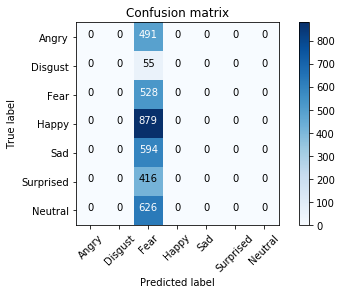

In [0]:
plot_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprised','Neutral']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [0]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)


In [0]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')